In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 24

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 5688.2835 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-01,128.970795,128.575684,128.582031,128.753738
AAPL,2023-01-08,128.411133,128.590469,128.270020,128.839127
AAPL,2023-01-15,128.896194,128.605255,129.308838,128.844254
AAPL,2023-01-22,128.489151,128.620056,130.797394,129.579315
AAPL,2023-01-29,128.810165,128.634842,131.616562,129.746231


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae          mse      mape       rmse    smape:
0  32.668182  1276.288815  0.195919  35.725185  22.08401

Model: AutoETS
         mae          mse      mape      rmse     smape:
0  32.598651  1268.372682  0.195552  35.61422  22.031586

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  29.560096  1063.17367  0.177003  32.606344  19.739586

Model: CES
         mae         mse      mape       rmse     smape:
0  32.229219  1239.85878  0.193341  35.211628  21.751136

Results for MSFT:
Model: AutoARIMA
         mae          mse      mape       rmse     smape:
0  72.331288  6737.746704  0.242022  82.083779  28.395426

Model: AutoETS
         mae         mse      mape       rmse    smape:
0  60.534371  4726.85661  0.202503  68.752139  23.09812

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  62.468173  4886.211418  0.209924  69.901441  23.964783

Model: CES
         mae          mse      mape  

In [8]:
cv_df = sf.cross_validation(df=Y_train_df, h=24, n_windows=3, step_size=24, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2021-08-21,2021-08-14,146.321793,146.785294,143.234726,150.335846,146.288956,126.442459,166.135452,145.547180,142.362885,148.796265,147.407593,142.267502,152.454086
AAPL,2021-08-28,2021-08-14,151.934387,147.459915,142.412613,152.507233,146.659729,118.483467,174.835999,139.869690,135.348160,144.833176,147.881775,142.757980,152.985947
AAPL,2021-09-04,2021-08-14,146.686096,147.568695,141.355057,153.782318,147.030502,112.386696,181.674316,140.149017,134.626144,145.758163,148.550217,143.461380,153.599274
AAPL,2021-09-11,2021-08-14,143.820709,147.775696,140.563843,154.987534,147.401276,107.241386,187.561172,137.564758,130.762726,144.784836,148.619705,143.342209,153.689301
AAPL,2021-09-18,2021-08-14,144.667511,148.797531,140.693039,156.902023,147.772049,102.696198,192.847916,138.313766,130.643173,144.883362,149.792709,144.515228,154.904953


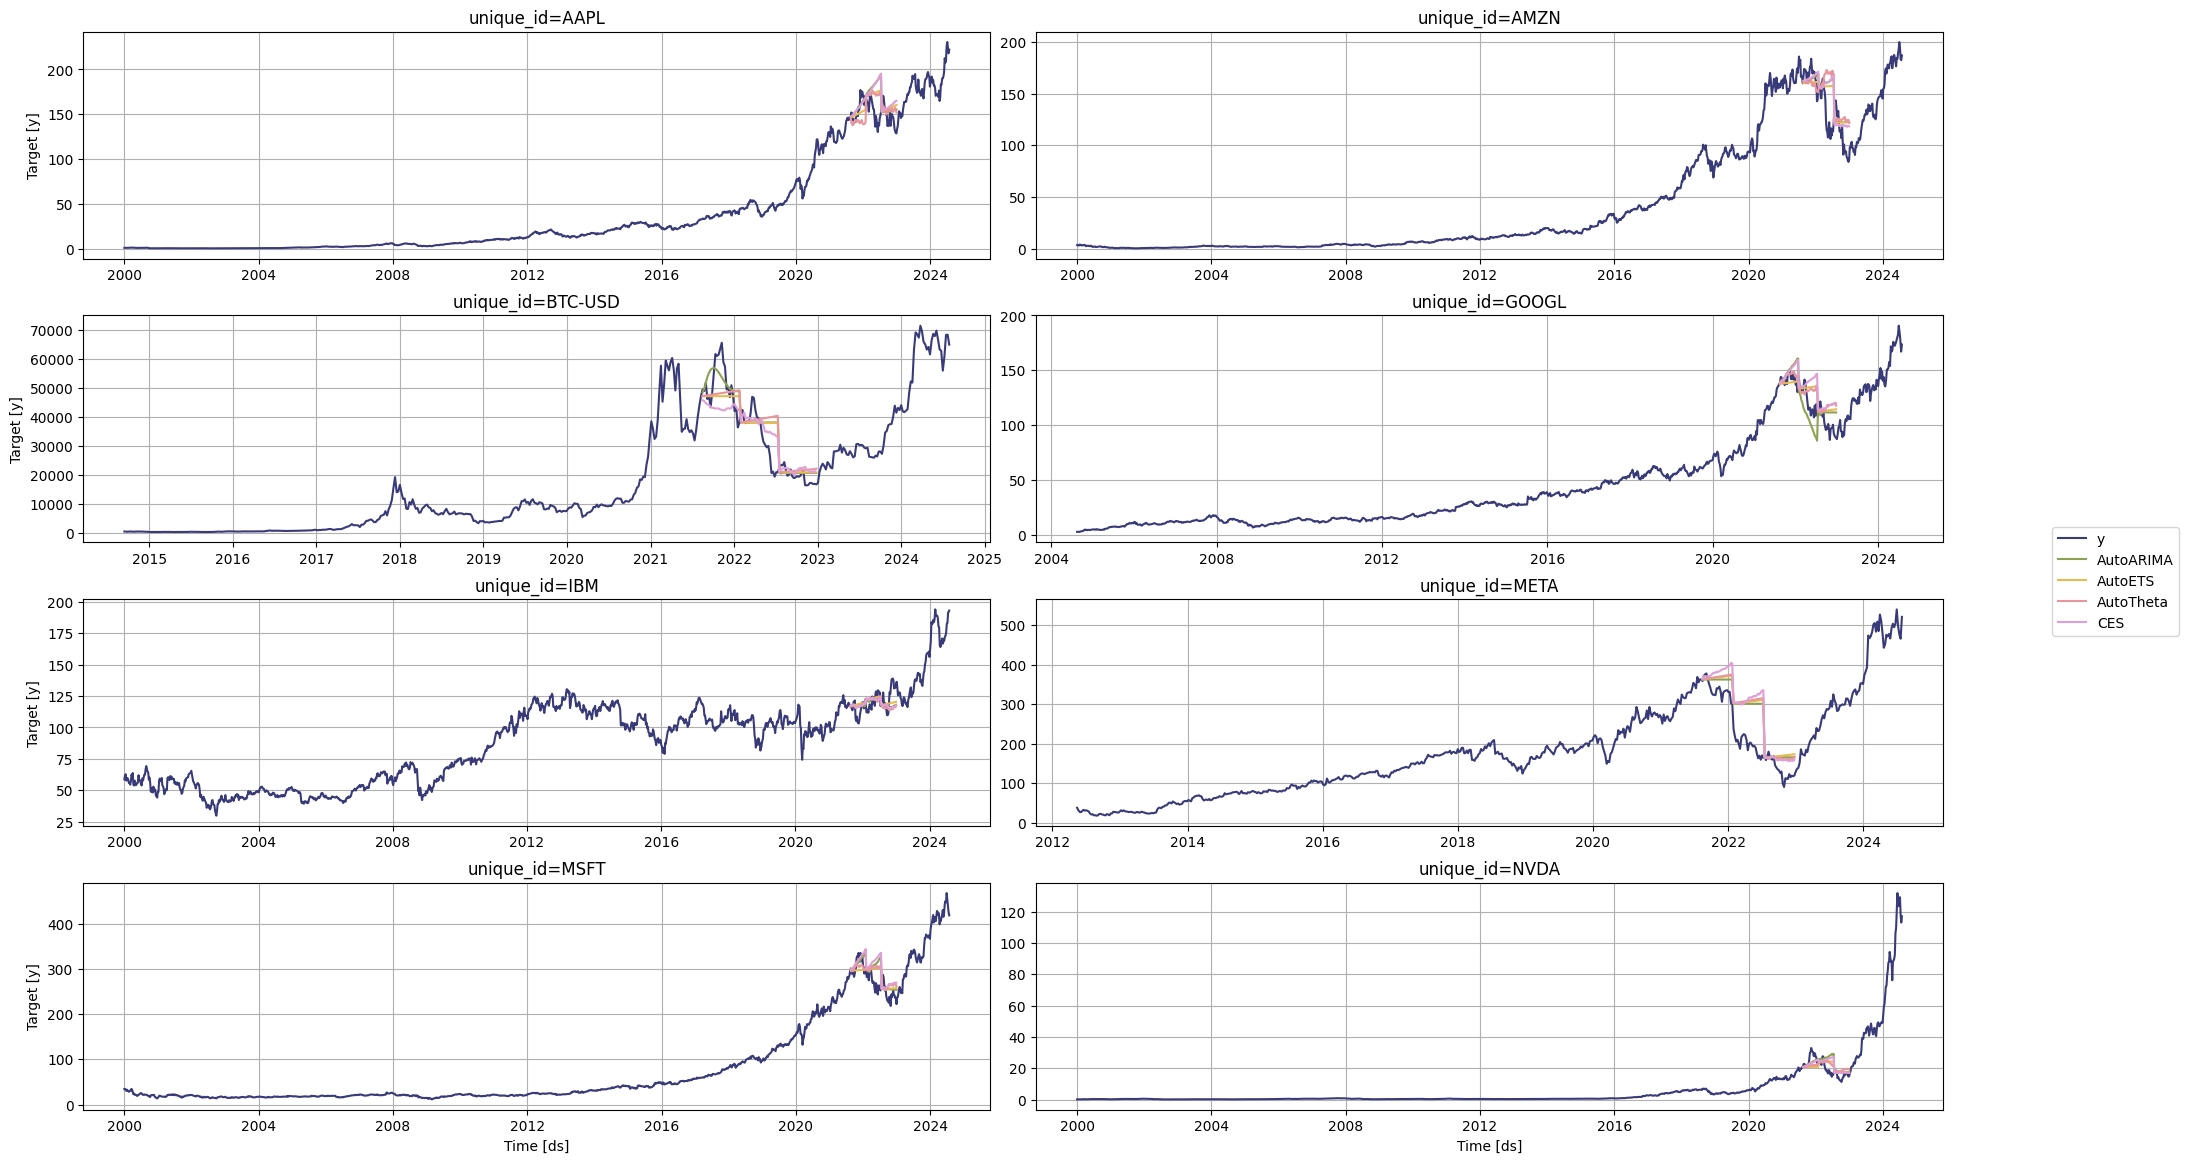

In [ ]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))